In [1]:
# Import Libraries
import numpy as np 
import pandas as pd 
import os

In [4]:
#Libraries
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Model

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

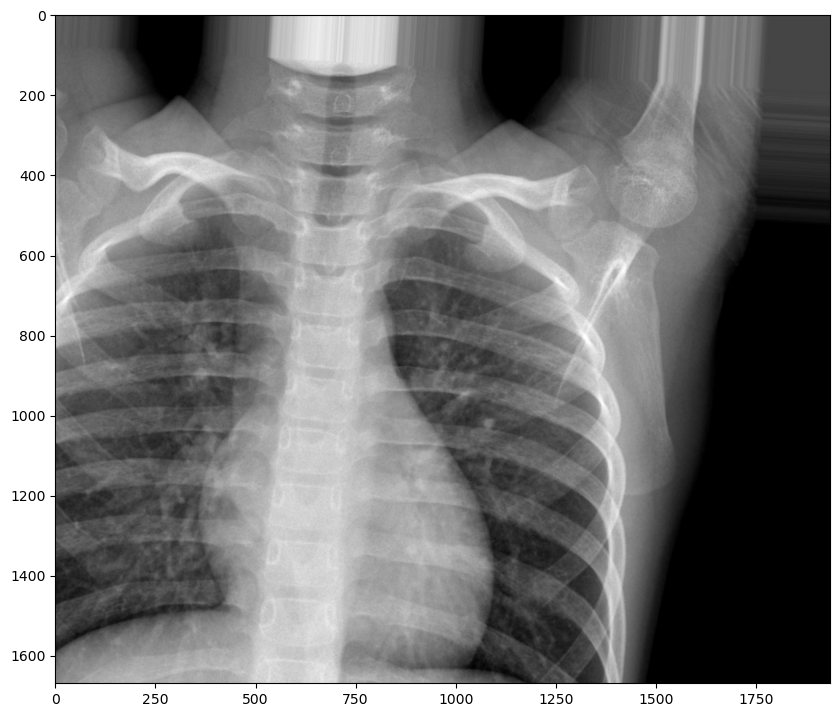

In [5]:
# simply show a picture
plt.figure(figsize= (10, 10))
img = mpimg.imread("C:\\Users\\BRAIN\\Desktop\\Alex the Analyst\\Machine Learning\\Lungs\\Lung Disease Dataset\\train\\Normal\\test_0_9774.jpeg")
plt.imshow(img)
plt.show()

In [7]:
# ImageDataGenerator (only can adjust on training data)
traingen = ImageDataGenerator(rescale= 1./255,
                             width_shift_range=0.2 , 
                             height_shift_range=0.2 ,
                             zoom_range=0.2)
valgen = ImageDataGenerator(rescale= 1./255)
testgen = ImageDataGenerator(rescale= 1./255)

In [8]:
# flow_from_directory
train_it = traingen.flow_from_directory("C:\\Users\\BRAIN\\Desktop\\Alex the Analyst\\Machine Learning\\Lungs\\Lung Disease Dataset\\train", target_size = (224, 224))
val_it = traingen.flow_from_directory("C:\\Users\\BRAIN\\Desktop\\Alex the Analyst\\Machine Learning\\Lungs\\Lung Disease Dataset\\val", target_size = (224, 224))
test_it = traingen.flow_from_directory("C:\\Users\\BRAIN\\Desktop\\Alex the Analyst\\Machine Learning\\Lungs\\Lung Disease Dataset\\test", target_size = (224, 224))

Found 6054 images belonging to 5 classes.
Found 2016 images belonging to 5 classes.
Found 2025 images belonging to 5 classes.


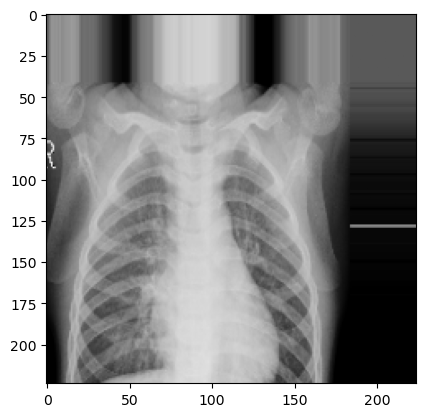

In [9]:
# show the picture after ImageDataGenerator
plt.figure()
plt.imshow(next(train_it)[0][0])
plt.show()

In [12]:
# use pre-train model of DenseNet201
base_model_201 = tf.keras.applications.DenseNet201(input_shape = (224, 224, 3),
    include_top=False,
    weights="imagenet"
)

# lock layers
for layer in base_model_201.layers:
  layer.trainable = False

# set full connect layers
x = layers.Flatten()(base_model_201.output)  # base_model_201.output
x = layers.Dropout(0.5)(x) # 
x = layers.Dense(512, activation= 'relu')(x)
x = layers.Dense(5, activation = 'softmax')(x)

model2 = tf.keras.models.Model(base_model_201.input, x)  # keras.models not keras.model

# compile
model2.compile('adam', loss = 'categorical_crossentropy',metrics = ['acc'])

#summary
model2.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_4 (ZeroPadding2  (None, 230, 230, 3)  0          ['input_3[0][0]']                
 D)                                                                                               
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d_4[0][0]']       
                                )                                                           

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

# use checkpoint to save the best model
# use ReduceLROnPlateau to automaticly turn down learning rate
Checkpoint = tf.keras.callbacks.ModelCheckpoint("densenet201.hdf5", monitor="val_acc", save_best_only= True, mode="max")
reduce_lr = ReduceLROnPlateau(monitor= "val_acc", factor= 0.5, patience= 4, verbose= 3,cooldown=2,  mode= "max", min_lr= 0.0000001)

model2.fit(train_it, validation_data= val_it, epochs=100, callbacks= [reduce_lr, Checkpoint], steps_per_epoch=60, validation_steps=10)

In [ ]:
#Evaluate
model_dense = keras.models.load_model('densenet201.hdf5')
model_dense.evaluate(test_it, steps= 1)